In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

import numpy as np
import json

In [21]:
# carregando o dataset principal
housing = pd.read_csv("data/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [20]:
# pegar o nome das cidades
gdf_points = gpd.GeoDataFrame(
    housing,
    geometry=gpd.points_from_xy(housing['longitude'], housing['latitude']),
    crs='EPSG:4326'
)

cities = gpd.read_file("data/tl_2023_06_place.shp").to_crs('EPSG:4326')
joined = gpd.sjoin(gdf_points, cities, how='left', predicate='within')

housing['city'] = joined['NAME']
housing = housing[housing["city"].isin(["San Francisco", "Sacramento"])]

# filtrando só pelas cidades desejadas e tirando nulos
housing.dropna()
housing = housing.drop(["latitude", "longitude","housing_median_age", "population", "median_income", "ocean_proximity"], axis = 1)
housing

,total_rooms,total_bedrooms,households,median_house_value,city
12461,5298.0,954.0,918.0,155700.0,Sacramento
12462,2507.0,446.0,448.0,163700.0,Sacramento
12463,1878.0,338.0,342.0,161400.0,Sacramento
12464,1806.0,339.0,341.0,147100.0,Sacramento
12465,2443.0,476.0,457.0,142000.0,Sacramento
...,...,...,...,...,...
16754,1046.0,251.0,239.0,224400.0,San Francisco
16755,2076.0,482.0,445.0,232100.0,San Francisco
16758,3615.0,632.0,615.0,314200.0,San Francisco
16759,1048.0,150.0,152.0,417600.0,San Francisco


In [154]:
housing.to_csv("data/housing_limpo.csv")

In [155]:
# definindo uma estrutura independente para representar a árvore
class TreeNode:
    def __init__(self, is_leaf=False, predicted_class=None, feature=None, threshold=None,
                 left=None, right=None, samples=None, impurity=None):
        # nó terminal
        self.is_leaf = is_leaf
        # classe prevista
        self.predicted_class = predicted_class
        # variável de separação
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.samples = samples
        self.impurity = impurity
    

    def extrai_cortes(self, feature_names=None):
        if self.is_leaf:
            return {"class": self.predicted_class}
        else:
            nome_feature = f"feature {self.feature}" if feature_names is None else feature_names[self.feature]
            corte_atual = {
                "feature": nome_feature,
                "threshold": self.threshold,
                "left": self.left.extrai_cortes(feature_names),
                "right": self.right.extrai_cortes(feature_names)
            }
        return corte_atual

# impureza do nó 
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return 1 - np.sum(p ** 2)

def construir_arvore(X, y, min_samples_leaf=1):
    # se só tem um tipo de classe ou poucas amostras, faz folha
    if len(np.unique(y)) == 1 or len(y) <= min_samples_leaf:
        pred_class = np.bincount(y).argmax()
        return TreeNode(is_leaf=True, predicted_class=pred_class, samples=len(y), impurity=gini_impurity(y))

    # procura o corte com a melhor pureza
    melhor_gini = gini_impurity(y)
    melhor_feature = None
    melhor_threshold = None
    melhor_split = None

    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if left_mask.sum() < min_samples_leaf or right_mask.sum() < min_samples_leaf:
                continue

            gini_left = gini_impurity(y[left_mask])
            gini_right = gini_impurity(y[right_mask])
            gini_total = (left_mask.sum() * gini_left + right_mask.sum() * gini_right) / n_samples

            if gini_total < melhor_gini:
                melhor_gini = gini_total
                melhor_feature = feature
                melhor_threshold = threshold
                melhor_split = (left_mask, right_mask)

    if melhor_feature is None:
        # nenhum split melhor, faz folha
        pred_class = np.bincount(y).argmax()
        return TreeNode(is_leaf=True, predicted_class=pred_class, samples=len(y), impurity=gini_impurity(y))

    # recursão nos filhos
    left_node = construir_arvore(X[melhor_split[0]], y[melhor_split[0]], min_samples_leaf)
    right_node = construir_arvore(X[melhor_split[1]], y[melhor_split[1]], min_samples_leaf)

    pred_class = np.bincount(y).argmax()
    return TreeNode(
        is_leaf=False,
        predicted_class=pred_class,
        feature=melhor_feature,
        threshold=melhor_threshold,
        left=left_node,
        right=right_node,
        samples=len(y),
        impurity=melhor_gini
    )


# funções auxiliares para previsão
def prever_exemplo(x, no):
    if no.is_leaf:
        return no.predicted_class
    if x[no.feature] < no.threshold:
        return prever_exemplo(x, no.left)
    else:
        return prever_exemplo(x, no.right)

def prever_amostras(X, raiz):
    return np.array([prever_exemplo(x, raiz) for x in X])

def accuracy(raiz, X, y):
    y_pred = prever_amostras(X, raiz)
    return accuracy_score(y, y_pred)

# poda nós irmãos (filhos do mesmo pai)
def poda_par_irmaos(no, X_val, y_val, min_ganho=0.0):
    # caso folha, nada a podar
    if no.is_leaf:
        return False

    podou_esq = False
    podou_dir = False
    if no.left:
        podou_esq = poda_par_irmaos(no.left, X_val, y_val, min_ganho)
    if no.right:
        podou_dir = poda_par_irmaos(no.right, X_val, y_val, min_ganho)

    # só poda se os dois filhos forem folhas
    if no.left and no.right and no.left.is_leaf and no.right.is_leaf:
        acc_antes = accuracy(no, X_val, y_val)

        # simula poda: faz nó atual virar folha com a classe majoritária
        no_backup = (no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right)
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        # classe majoritária do val (alternativo: da amostra do nó)
        no.predicted_class = np.bincount(y_val).argmax()  

        acc_depois = accuracy(no, X_val, y_val)
        ganho = acc_depois - acc_antes

        if ganho >= min_ganho: 
        # se melhorar então realiza a poda
            return True  
        else:
            # desfaz poda
            no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right = no_backup
            return podou_esq or podou_dir

    return podou_esq or podou_dir

def podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.0):
    while True:
        podou = poda_par_irmaos(raiz, X_val, y_val, min_ganho)
        if not podou:
            break

def plotar_arvore_dinamica(no, feature_names, ax=None, pos=None, x=0, y=0, nivel=0, contador=None, conexoes=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.axis('off')
        pos = {}
        conexoes = []
        # contador mutável para a posição X das folhas
        contador = [0]  

    if no.is_leaf:
        pos[no] = (contador[0], -nivel)
        contador[0] += 1
    else:
        # calcula posições dos filhos
        plotar_arvore_dinamica(no.left, feature_names, ax, pos, x, y, nivel + 1, contador, conexoes)
        plotar_arvore_dinamica(no.right, feature_names, ax, pos, x, y, nivel + 1, contador, conexoes)
        x_esq, _ = pos[no.left]
        x_dir, _ = pos[no.right]
        pos[no] = ((x_esq + x_dir) / 2, -nivel)
        conexoes.append((pos[no], pos[no.left]))
        conexoes.append((pos[no], pos[no.right]))

    x_no, y_no = pos[no]

    if no.is_leaf:
        texto = f"[{no.predicted_class}]"
        cor = 'lightgreen'
    else:
        feat = feature_names[no.feature]
        texto = f"{feat} < {no.threshold:.2f}"
        cor = 'lightblue'

    ax.text(x_no, y_no, texto, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', fc=cor, ec='black'), fontsize=6)

    # desenha as conexões
    if nivel == 0:
        for (p1, p2) in conexoes:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', lw=1)

        plt.title('Árvore de Decisão Personalizada')
        plt.tight_layout()
        plt.show()

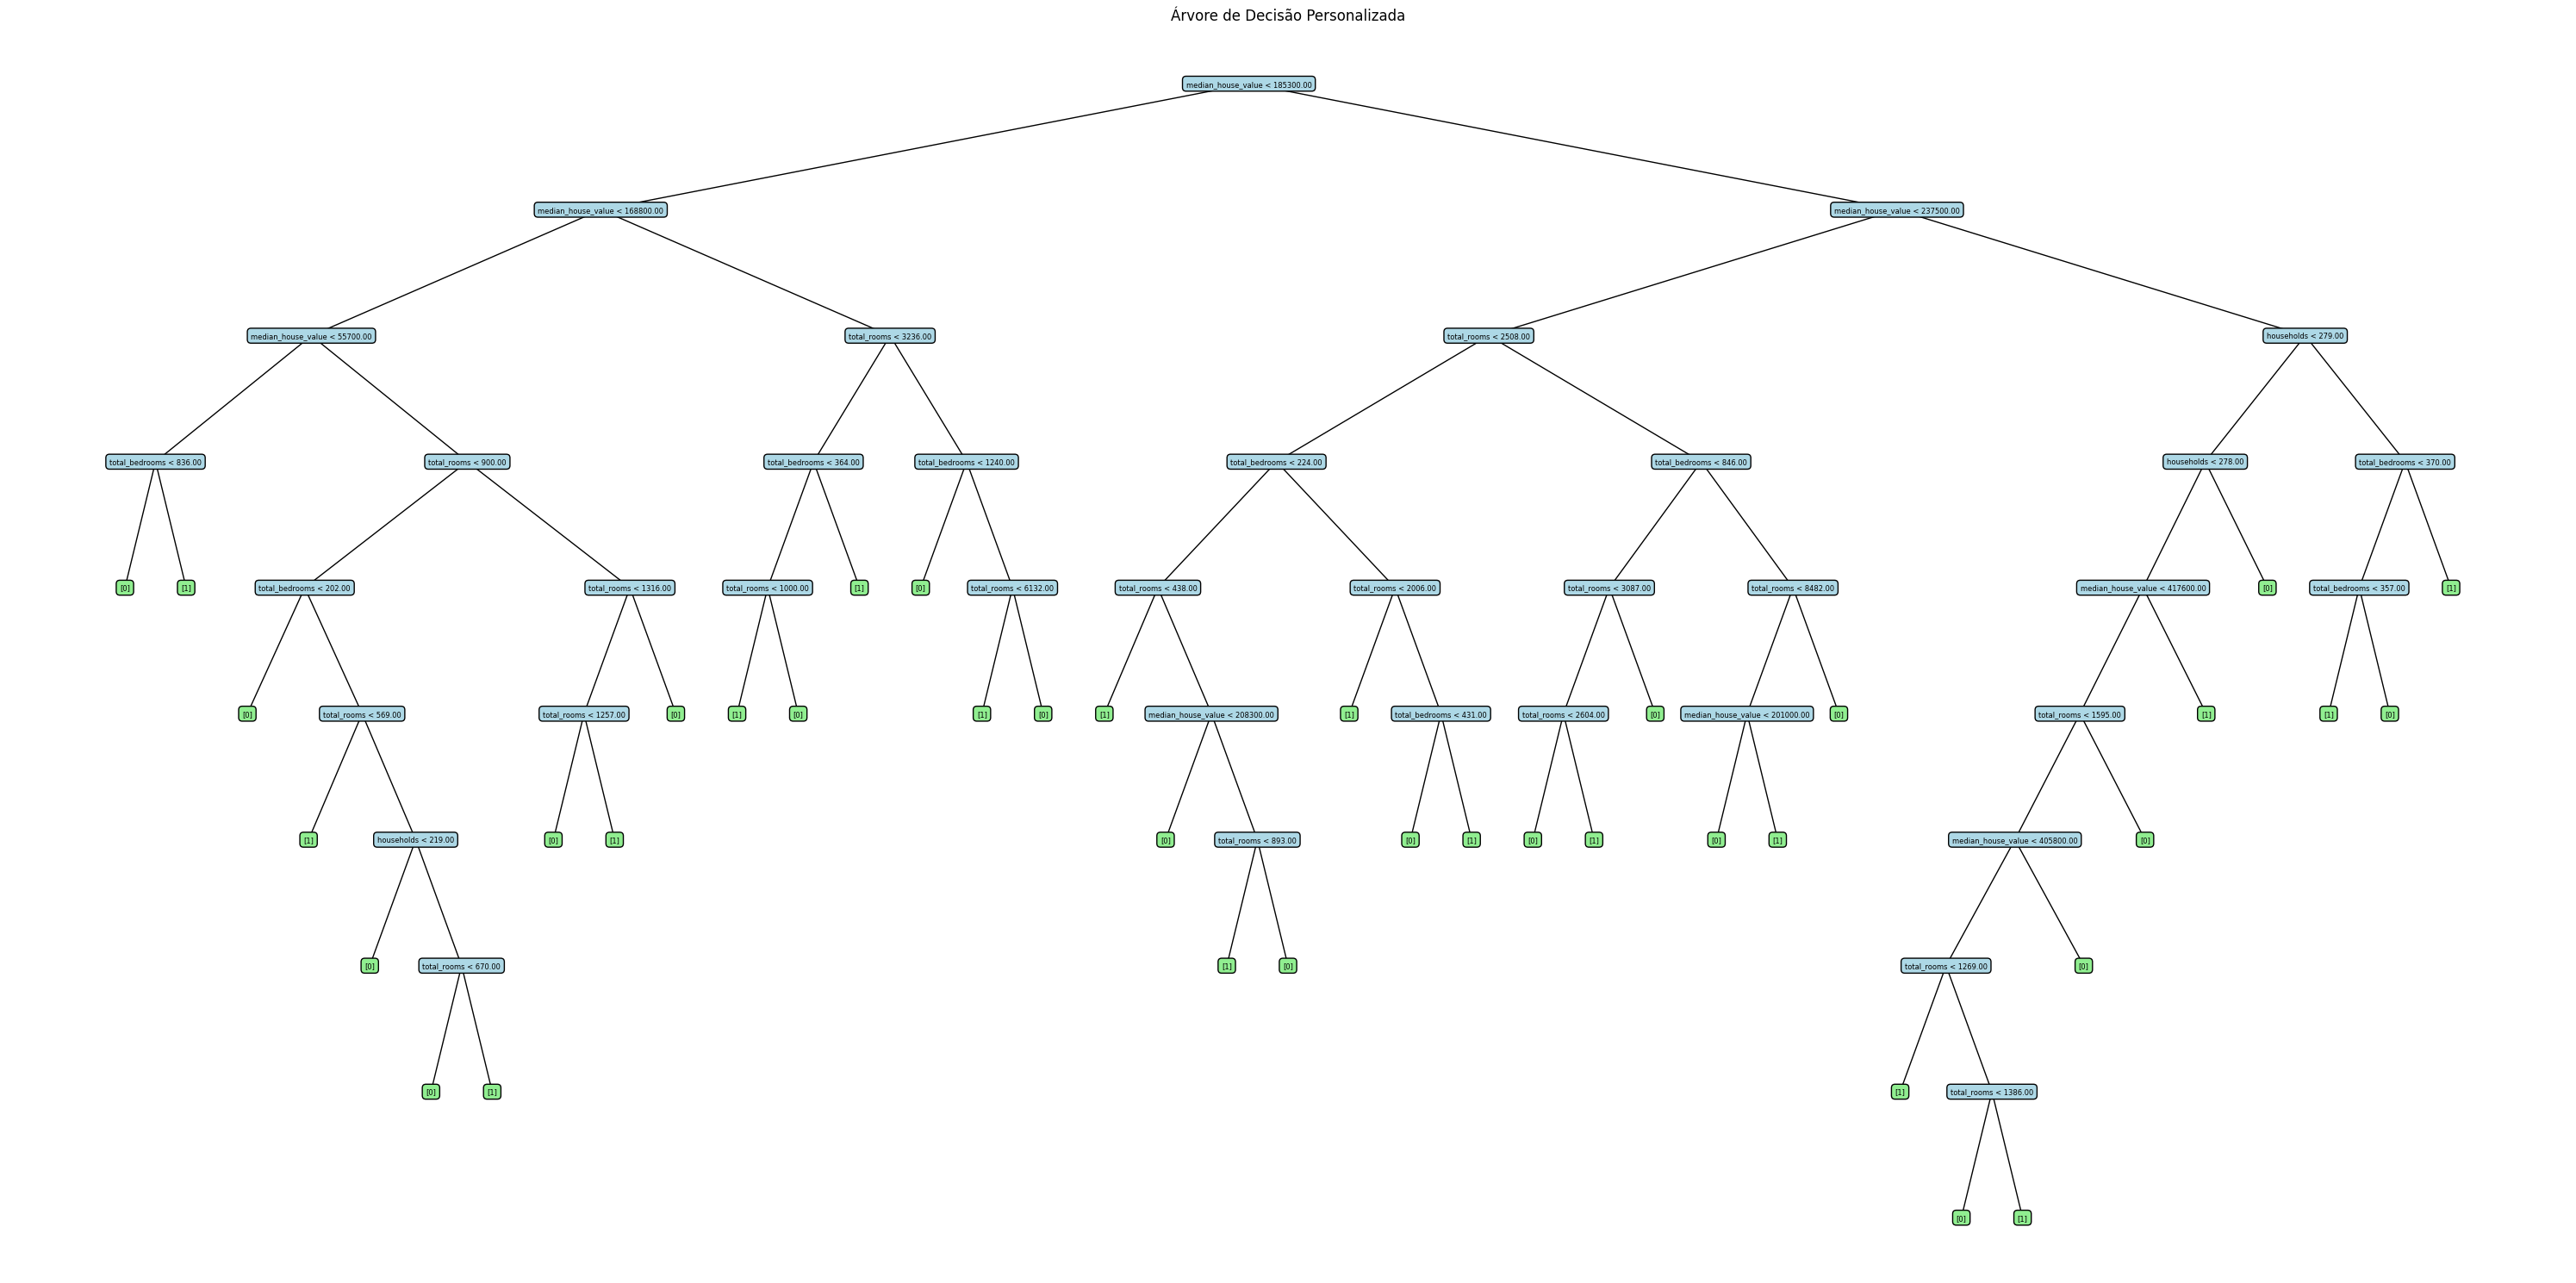

Acurácia treino antes poda: 1.0
Acurácia validação antes poda: 0.875968992248062


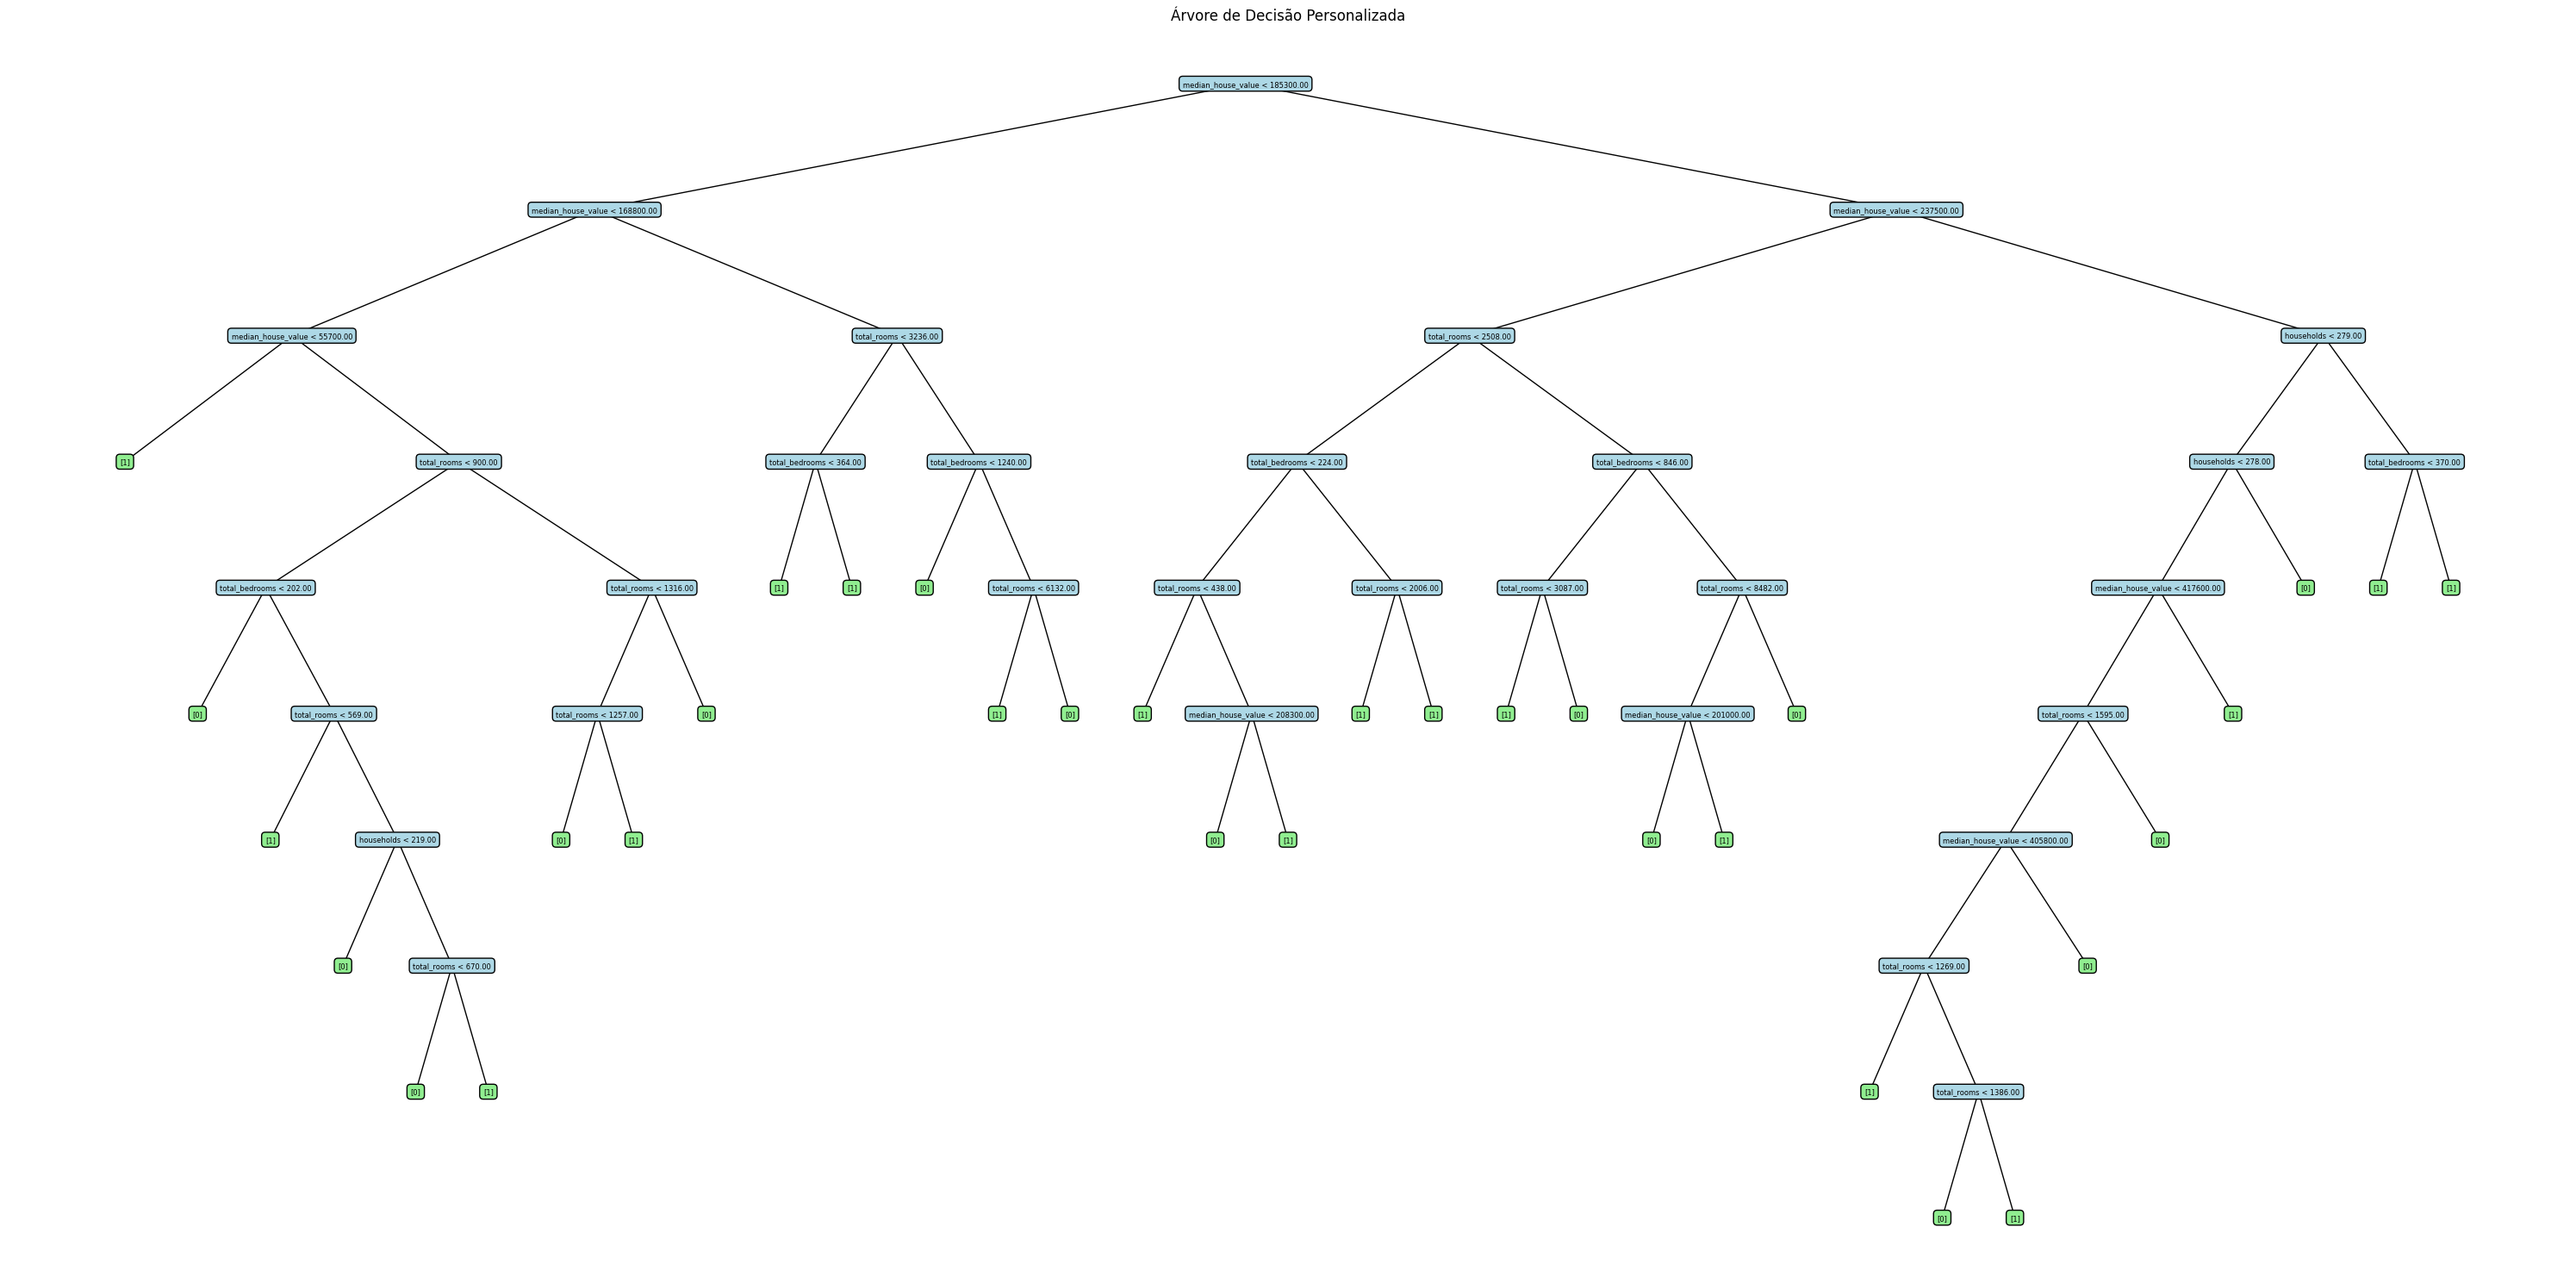

Acurácia treino após poda: 0.9766277128547579
Acurácia validação após poda: 0.9069767441860465


In [156]:
X = housing.drop(columns=["city"]).values
y = housing["city"].map({"Sacramento": 0, "San Francisco": 1}).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=160)

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X_train, y_train, min_samples_leaf=1)
plotar_arvore_dinamica(raiz, feature_names=["total_rooms", "total_bedrooms", "households", "median_house_value"])
raiz_completa = raiz.extrai_cortes()

print("Acurácia treino antes poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação antes poda:", accuracy(raiz, X_val, y_val))

# Poda com base na validação
podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.1)
plotar_arvore_dinamica(raiz, feature_names=["total_rooms", "total_bedrooms", "households", "median_house_value"])
raiz_poda = raiz.extrai_cortes()

print("Acurácia treino após poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação após poda:", accuracy(raiz, X_val, y_val))

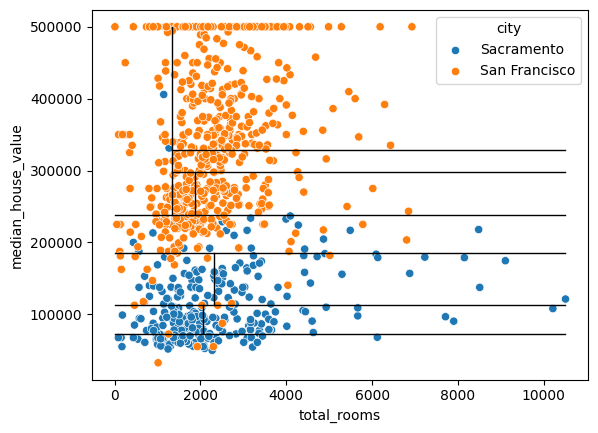

In [166]:
# dataset 2D

housing = pd.read_csv("static/data/housing_limpo.csv")
X = housing[["total_rooms", "median_house_value"]].values
y = housing["city"].map({"Sacramento": 0, "San Francisco": 1}).values

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X, y, min_samples_leaf=50)

def subdividir(ax, bbox, corte, feature_names):
    if "class" in corte:
        return

    x0, y0, x1, y1 = bbox
    feature = corte["feature"]
    threshold = float(corte["threshold"])  # garantir que seja float normal

    if feature == feature_names[0]:  # corte vertical (x = threshold)
        ax.plot([threshold, threshold], [y0, y1], color='black', linewidth=1)
        subdividir(ax, (x0, y0, threshold, y1), corte.get("left"), feature_names)
        subdividir(ax, (threshold, y0, x1, y1), corte.get("right"), feature_names)

    elif feature == feature_names[1]:  # corte horizontal (y = threshold)
        ax.plot([x0, x1], [threshold, threshold], color='black', linewidth=1)
        subdividir(ax, (x0, y0, x1, threshold), corte.get("left"), feature_names)
        subdividir(ax, (x0, threshold, x1, y1), corte.get("right"), feature_names)

fig, ax = plt.subplots()

corte_raiz_2d = raiz.extrai_cortes(["total_rooms", "median_house_value"])
bbox = (0, 0, housing["total_rooms"].max(), housing["median_house_value"].max())

subdividir(ax, bbox, corte_raiz_2d, feature_names=["total_rooms", "median_house_value"])

df = housing#[housing["city"] == "Sacramento"]
sns.scatterplot(df, x = housing["total_rooms"], y = housing["median_house_value"], hue = "city")
plt.show()


In [158]:
# salvando a estrutura de cortes em um json
def converter(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    raise TypeError(f"Tipo {type(obj)} não é serializável")

# Salvar em cortes.txt (ou .json)
with open("cortes_2d.json", "w") as f:
    json.dump(corte_raiz_2d, f, default=converter, indent=2)

    # Salvar em cortes.txt (ou .json)
with open("cortes_completa.json", "w") as f:
    json.dump(raiz_completa, f, default=converter, indent=2)

with open("cortes_poda.json", "w") as f:
    json.dump(raiz_poda, f, default=converter, indent=2)

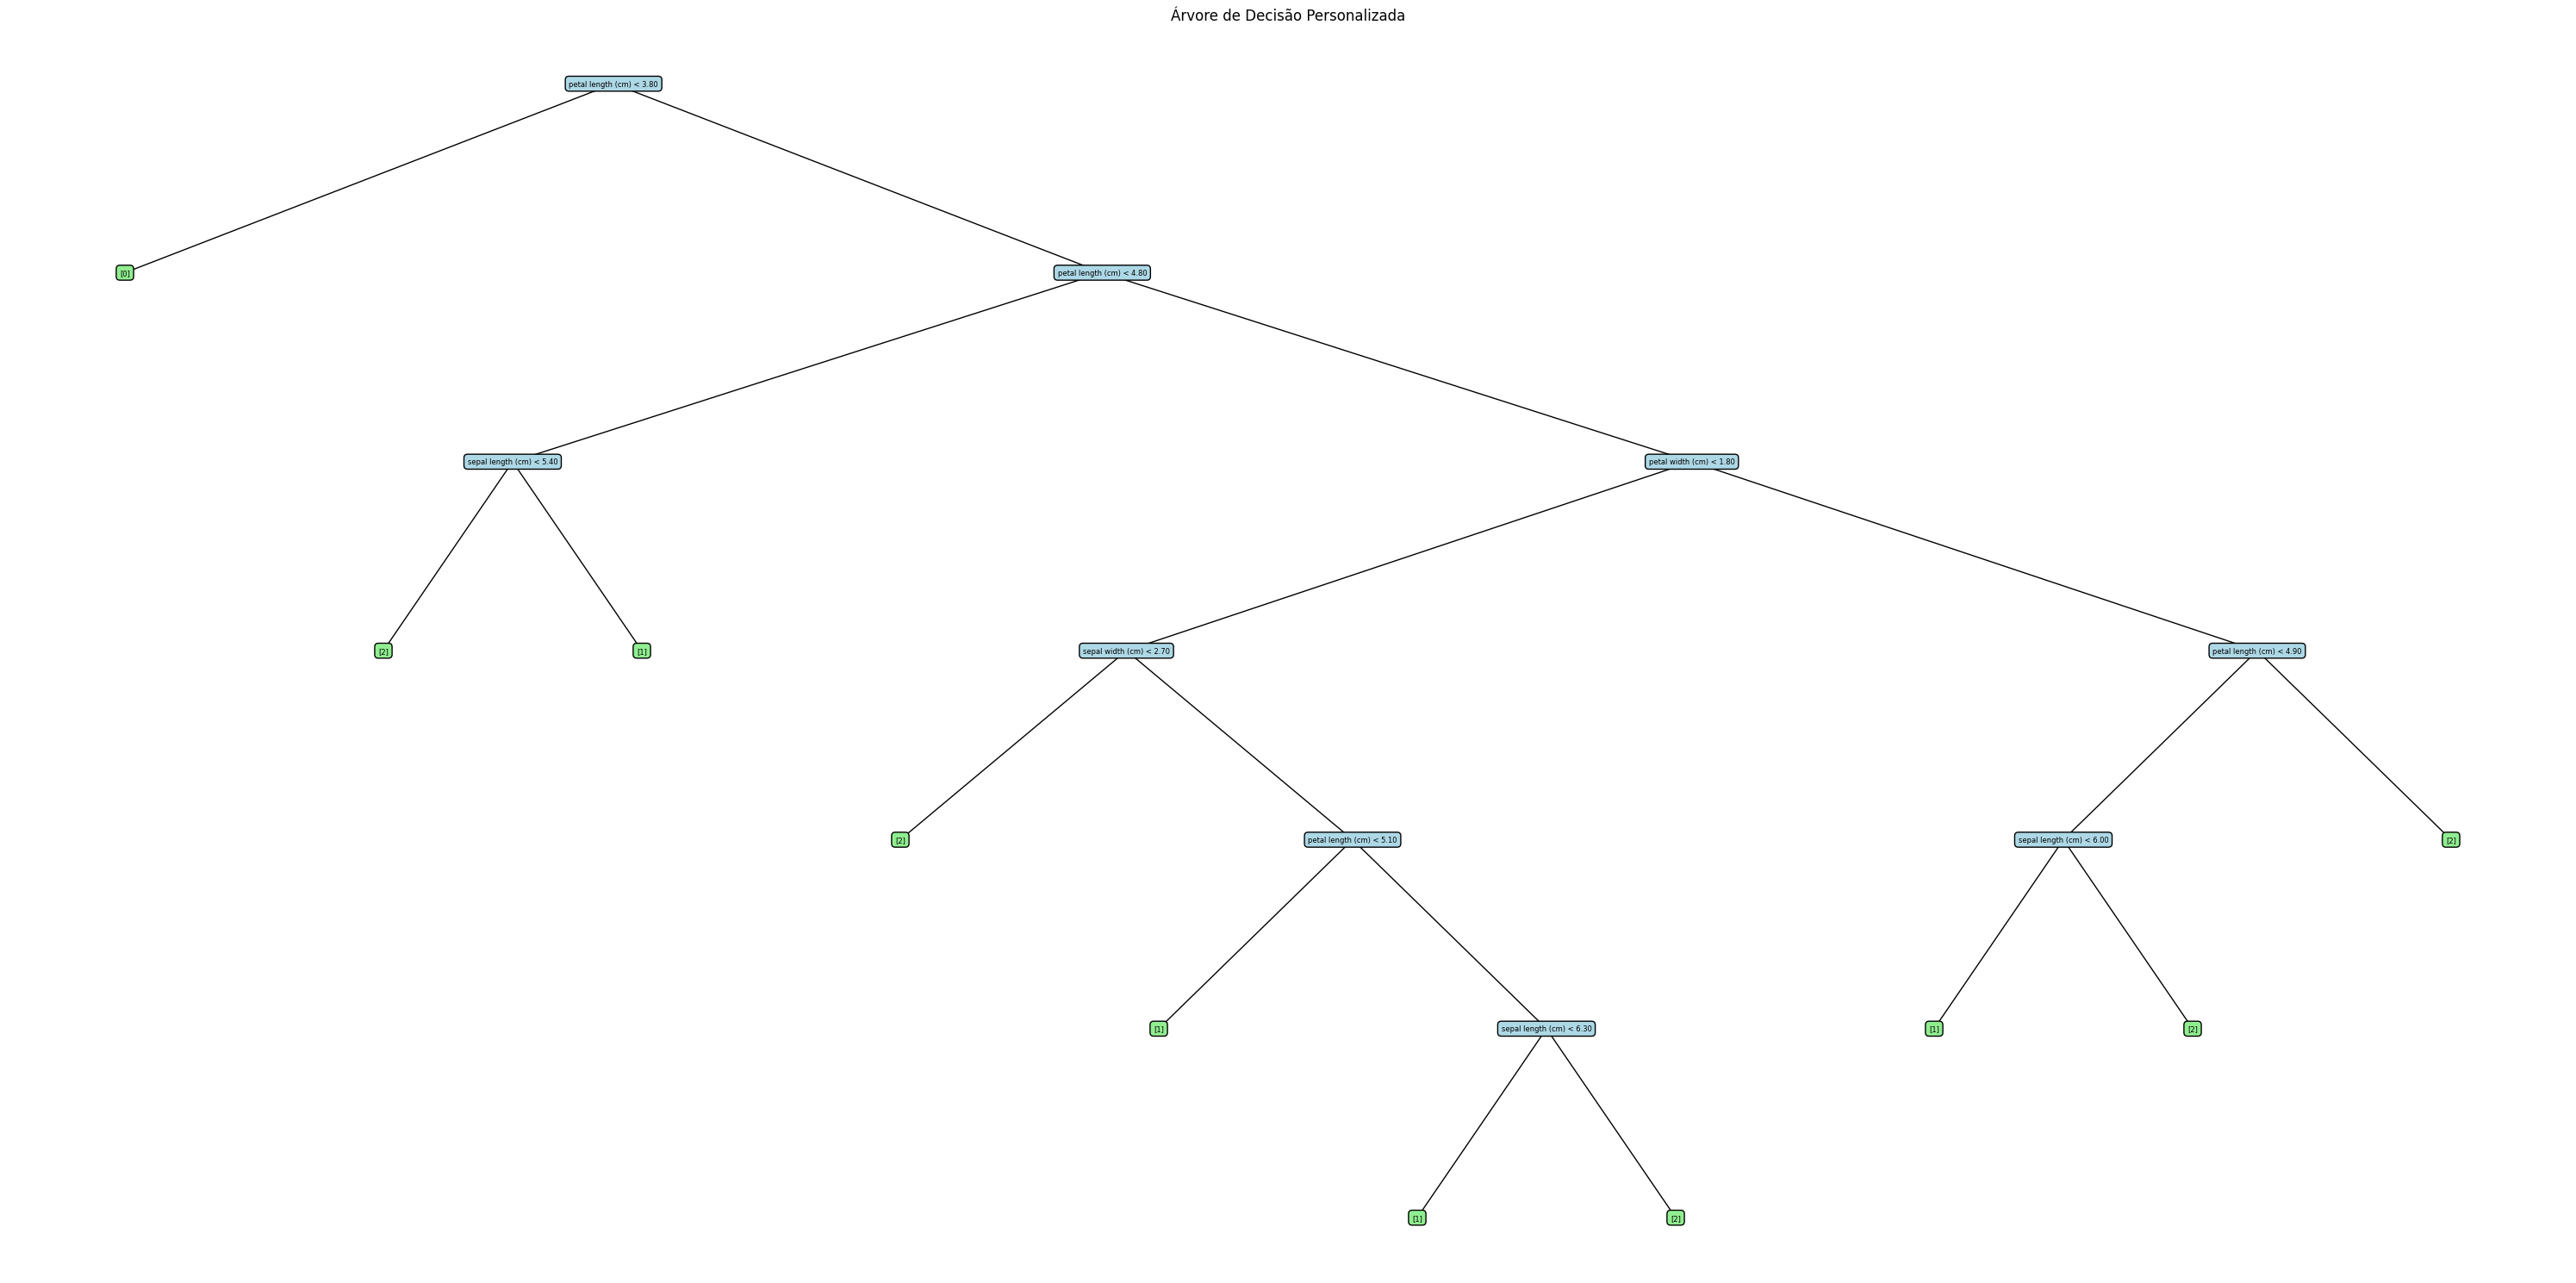

Acurácia treino antes poda: 1.0
Acurácia validação antes poda: 0.8


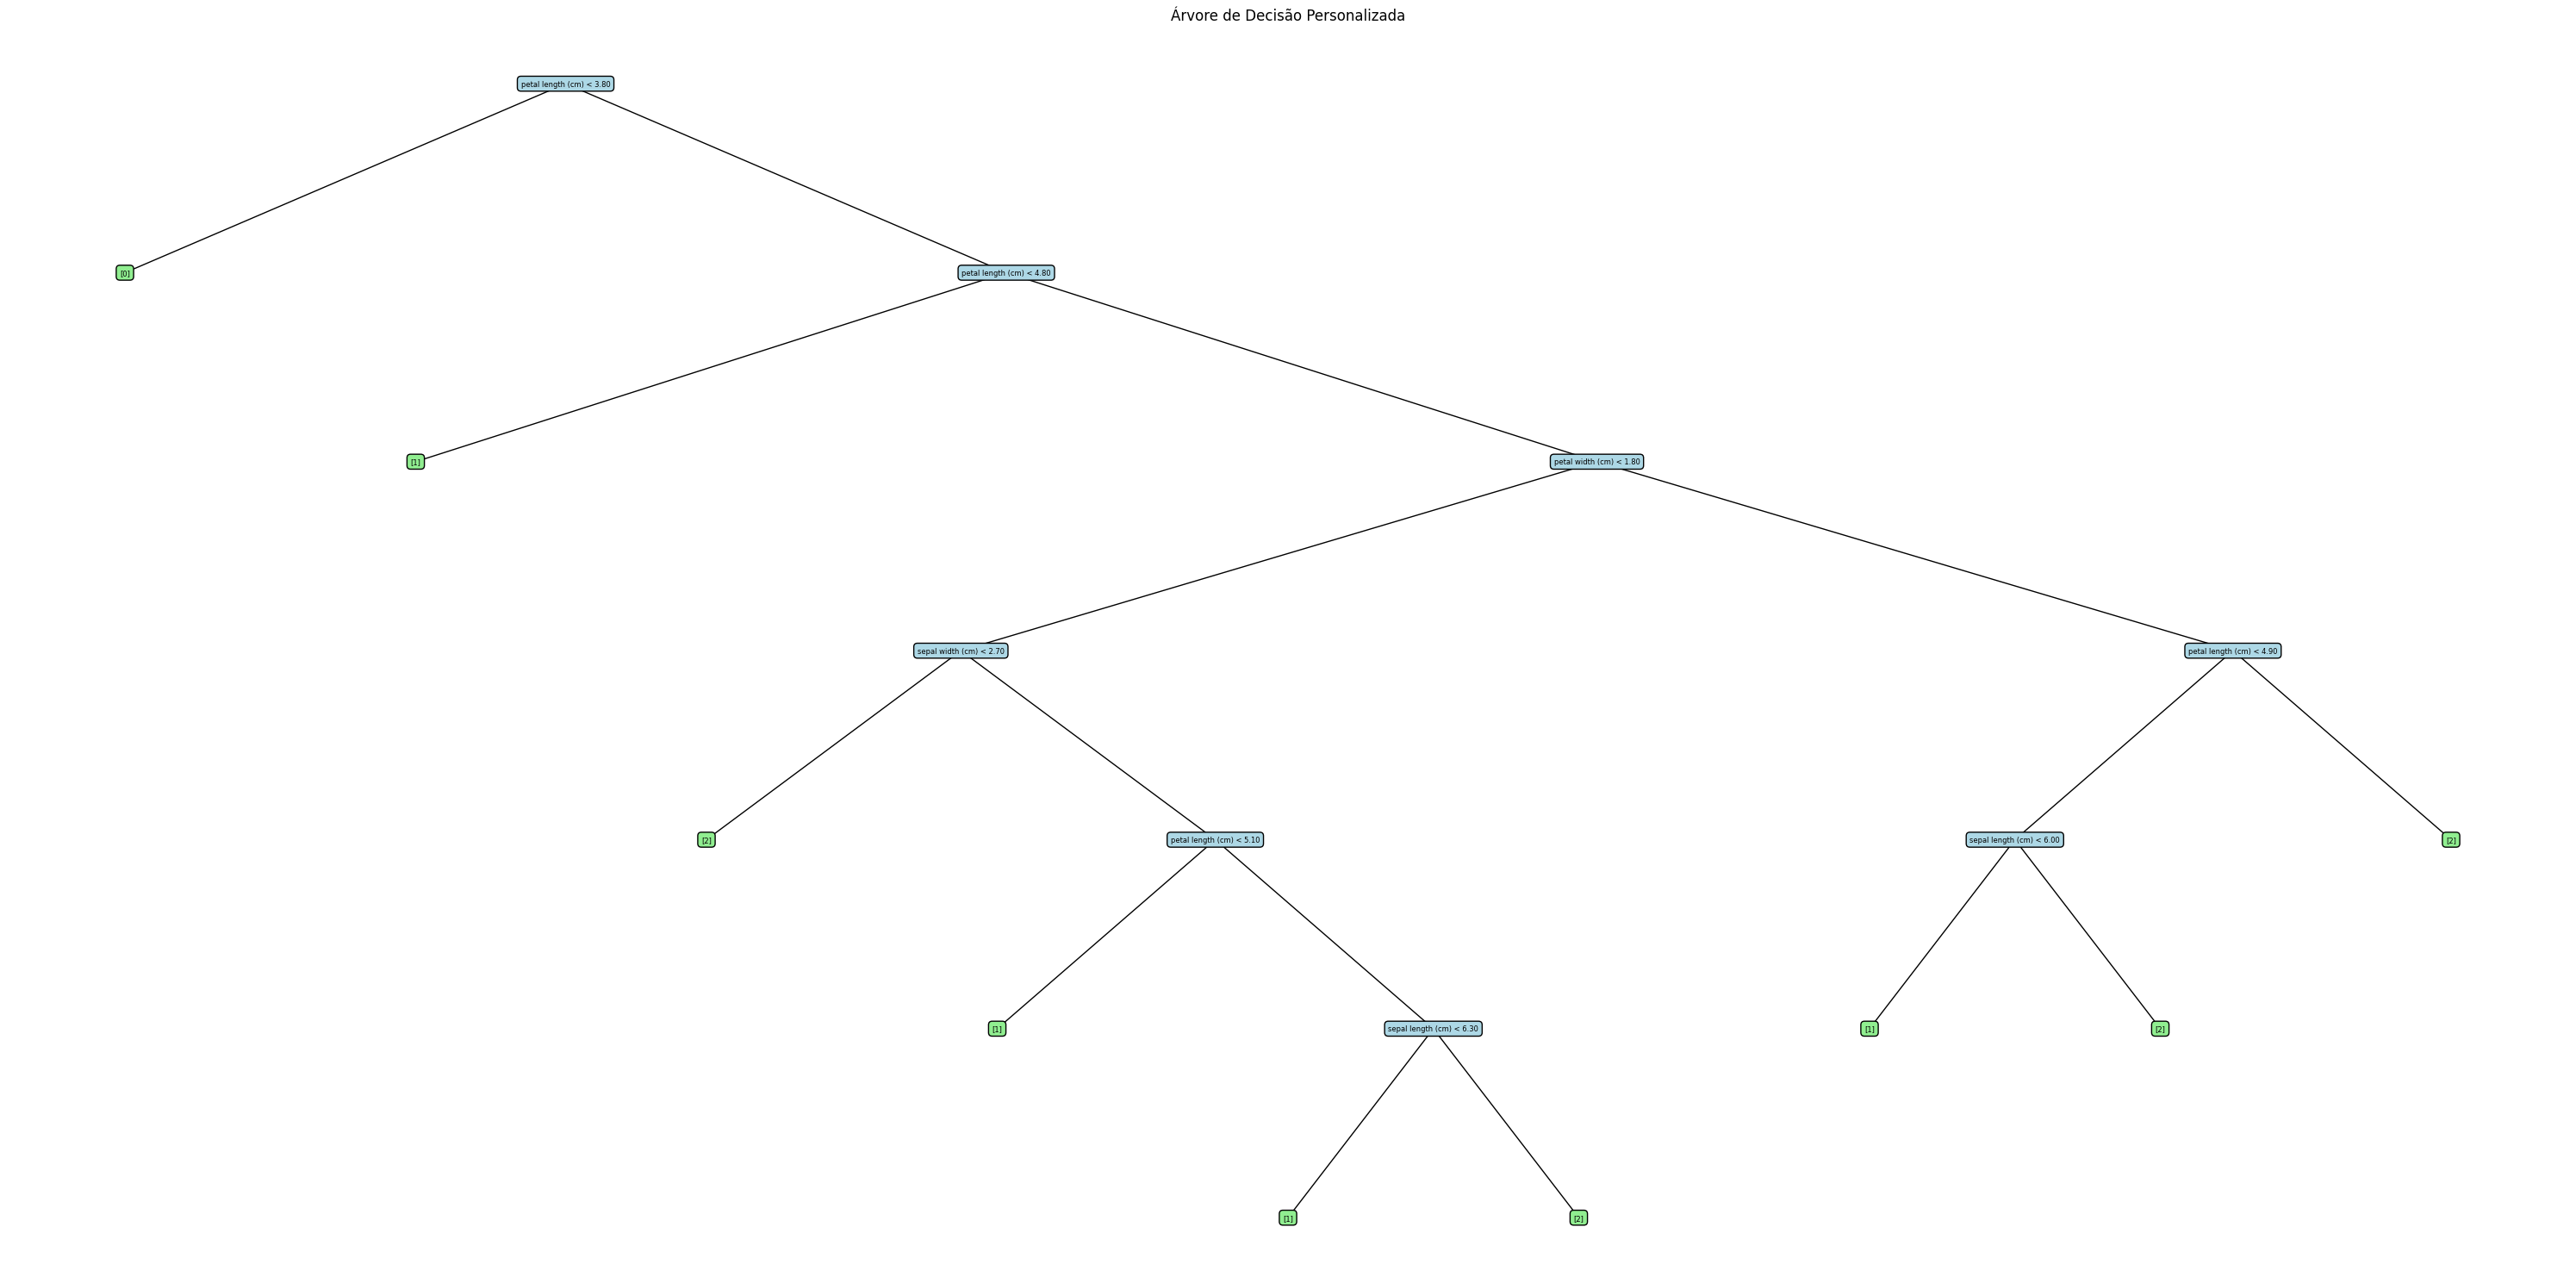

Acurácia treino após poda: 0.9904761904761905
Acurácia validação após poda: 0.8222222222222222


In [159]:
# testando com um dataset menor

iris = load_iris()
X = iris.data  
y = iris.target 
feature_names = iris.feature_names
class_names = iris.target_names


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=170)

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X_train, y_train, min_samples_leaf=1)
plotar_arvore_dinamica(raiz, feature_names=feature_names)

print("Acurácia treino antes poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação antes poda:", accuracy(raiz, X_val, y_val))

# Poda com base na validação
podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.1)
plotar_arvore_dinamica(raiz, feature_names=feature_names)

print("Acurácia treino após poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação após poda:", accuracy(raiz, X_val, y_val))

# Criando json

In [167]:
def cortes_para_json(corte, feature_names):
    if "class" in corte:
        return {
            "name": f"Classe: {corte['class']}"
        }

    feature_idx = int(corte["feature"].split()[-1])

    if feature_idx >= len(feature_names):
        feature_name = f"{feature_names}"  # fallback
    else:
        feature_name = feature_names[feature_idx]

    threshold = float(corte["threshold"])

    return {
        "name": f"{feature_name} ≤ {threshold:.2f}",
        "children": [
            cortes_para_json(corte["left"], feature_names),
            cortes_para_json(corte["right"], feature_names)
        ]
    }


In [168]:
feature_names = ["total_bedrooms", "median_house_value"]  # ou as colunas de X
corte_raiz_2d = raiz.extrai_cortes()
arvore_json = cortes_para_json(corte_raiz_2d, feature_names)

with open("arvore_d3.json", "w") as f:
    json.dump(arvore_json, f, indent=2)


## Implementacao de Poda

In [12]:
import copy

# Poda por Custo-Complexidade (Cost-Complexity Pruning)
def calcular_custo_complexidade(no, alpha):
    if no.is_leaf:
        return no.impurity * no.samples
    
    custo_esq = calcular_custo_complexidade(no.left, alpha)
    custo_dir = calcular_custo_complexidade(no.right, alpha)
    custo_folhas = custo_esq + custo_dir + alpha
    custo_no = no.impurity * no.samples
    
    return min(custo_folhas, custo_no)

def poda_custo_complexidade(no, alpha):
    if no.is_leaf:
        return False
    
    podou_esq = False
    podou_dir = False
    
    if no.left:
        podou_esq = poda_custo_complexidade(no.left, alpha)
    if no.right:
        podou_dir = poda_custo_complexidade(no.right, alpha)
    
    custo_esq = calcular_custo_complexidade(no.left, alpha) if no.left else 0
    custo_dir = calcular_custo_complexidade(no.right, alpha) if no.right else 0
    custo_folhas = custo_esq + custo_dir + alpha
    custo_no = no.impurity * no.samples
    
    if custo_no <= custo_folhas:
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        return True
    
    return podou_esq or podou_dir

# Poda por Profundidade Máxima
def poda_profundidade(no, max_depth, depth=0):
    if no.is_leaf or depth >= max_depth:
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        return True
    
    podou_esq = False
    podou_dir = False
    
    if no.left:
        podou_esq = poda_profundidade(no.left, max_depth, depth + 1)
    if no.right:
        podou_dir = poda_profundidade(no.right, max_depth, depth + 1)
    
    return podou_esq or podou_dir

# Função para criar cópias da árvore
def copiar_arvore(no):
    if no is None:
        return None
    
    novo_no = TreeNode(
        is_leaf=no.is_leaf,
        predicted_class=no.predicted_class,
        feature=no.feature,
        threshold=no.threshold,
        samples=no.samples,
        impurity=no.impurity
    )
    
    if not no.is_leaf:
        novo_no.left = copiar_arvore(no.left)
        novo_no.right = copiar_arvore(no.right)
    
    return novo_no

In [ ]:
# Criando árvores mais complexas - Housing dataset
housing_novo = pd.read_csv("data/housing_limpo.csv")
print(f"Dataset shape: {housing_novo.shape}")
print(f"Distribuição: {housing_novo['city'].value_counts()}")

# Preparar dados IGUAL aos originais para ter mesma complexidade
X_novo = housing_novo.drop(columns=["city"]).values  
y_novo = housing_novo["city"].map({"Sacramento": 0, "San Francisco": 1}).values

# Usar MESMOS parâmetros que geraram árvores originais complexas
X_train_novo, X_val_novo, y_train_novo, y_val_novo = train_test_split(X_novo, y_novo, test_size=0.3, random_state=160)
feature_names_novo = ["total_rooms", "total_bedrooms", "households", "median_house_value"]

print(f"\nTreino: {len(X_train_novo)}, Validação: {len(X_val_novo)}")

# 1. Árvore MUITO complexa (min_samples_leaf=1)
print("\n=== CRIANDO ÁRVORES COMPLEXAS ===")
arvore_completa_novo = construir_arvore(X_train_novo, y_train_novo, min_samples_leaf=1)
cortes_completa_novo = arvore_completa_novo.extrai_cortes(feature_names_novo)

print(f"\n1. Árvore Completa:")
print(f"   Treino: {accuracy(arvore_completa_novo, X_train_novo, y_train_novo):.3f}")
print(f"   Validação: {accuracy(arvore_completa_novo, X_val_novo, y_val_novo):.3f}")

# 2. Poda por validação (mais agressiva)
arvore_poda_val_novo = copiar_arvore(arvore_completa_novo)
podar_ate_convergir(arvore_poda_val_novo, X_val_novo, y_val_novo, min_ganho=-0.01)  # permite pequena perda
cortes_poda_val_novo = arvore_poda_val_novo.extrai_cortes(feature_names_novo)

print(f"\n2. Poda Validação:")
print(f"   Treino: {accuracy(arvore_poda_val_novo, X_train_novo, y_train_novo):.3f}")
print(f"   Validação: {accuracy(arvore_poda_val_novo, X_val_novo, y_val_novo):.3f}")

# 3. Poda por custo-complexidade (alpha menor)
arvore_poda_custo_novo = copiar_arvore(arvore_completa_novo)
poda_custo_complexidade(arvore_poda_custo_novo, alpha=0.0001)
cortes_poda_custo_novo = arvore_poda_custo_novo.extrai_cortes(feature_names_novo)

print(f"\n3. Poda Custo-Complexidade:")
print(f"   Treino: {accuracy(arvore_poda_custo_novo, X_train_novo, y_train_novo):.3f}")
print(f"   Validação: {accuracy(arvore_poda_custo_novo, X_val_novo, y_val_novo):.3f}")

# 4. Poda por profundidade (mais profunda)
arvore_poda_prof_novo = copiar_arvore(arvore_completa_novo)
poda_profundidade(arvore_poda_prof_novo, max_depth=8)
cortes_poda_prof_novo = arvore_poda_prof_novo.extrai_cortes(feature_names_novo)

print(f"\n4. Poda Profundidade:")
print(f"   Treino: {accuracy(arvore_poda_prof_novo, X_train_novo, y_train_novo):.3f}")
print(f"   Validação: {accuracy(arvore_poda_prof_novo, X_val_novo, y_val_novo):.3f}")

print("\n=== ESTRUTURAS DAS ÁRVORES ===")

def contar_nos(corte):
    if "class" in corte:
        return 1
    return 1 + contar_nos(corte["left"]) + contar_nos(corte["right"])

print(f"Nós árv completa NOVA: {contar_nos(cortes_completa_novo)}")
print(f"Nós poda validação NOVA: {contar_nos(cortes_poda_val_novo)}")
print(f"Nós poda custo NOVA: {contar_nos(cortes_poda_custo_novo)}")
print(f"Nós poda profund NOVA: {contar_nos(cortes_poda_prof_novo)}")

Dataset shape: (857, 6)
Distribuição: city
San Francisco    575
Sacramento       282
Name: count, dtype: int64

Treino: 599, Validação: 258

=== CRIANDO ÁRVORES COMPLEXAS ===

1. Árvore Completa:
   Treino: 1.000
   Validação: 0.996

2. Poda Validação:
   Treino: 0.998
   Validação: 0.996

3. Poda Custo-Complexidade:
   Treino: 0.998
   Validação: 0.996

4. Poda Profundidade:
   Treino: 1.000
   Validação: 0.996

=== ESTRUTURAS DAS ÁRVORES ===
Nós árv completa NOVA: 5
Nós poda validação NOVA: 3
Nós poda custo NOVA: 3
Nós poda profund NOVA: 5


In [29]:
# Salvar JSONs dos diferentes métodos de poda - NOVAS VERSÕES
def converter(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    raise TypeError(f"Tipo {type(obj)} não é serializável")

# Salvar árvore completa NOVA
with open("static/trees/housing_completa_nova.json", "w") as f:
    json.dump(cortes_completa_novo, f, default=converter, indent=2)

# Salvar árvore com poda por validação NOVA
with open("static/trees/housing_poda_validacao_nova.json", "w") as f:
    json.dump(cortes_poda_val_novo, f, default=converter, indent=2)

# Salvar árvore com poda por custo-complexidade NOVA
with open("static/trees/housing_poda_custo_nova.json", "w") as f:
    json.dump(cortes_poda_custo_novo, f, default=converter, indent=2)

# Salvar árvore com poda por profundidade NOVA
with open("static/trees/housing_poda_profundidade_nova.json", "w") as f:
    json.dump(cortes_poda_prof_novo, f, default=converter, indent=2)

print("JSONs NOVOS salvos em static/trees/")

JSONs NOVOS salvos em static/trees/



=== Visualizações das Árvores ===

1. Árvore Completa (Housing):


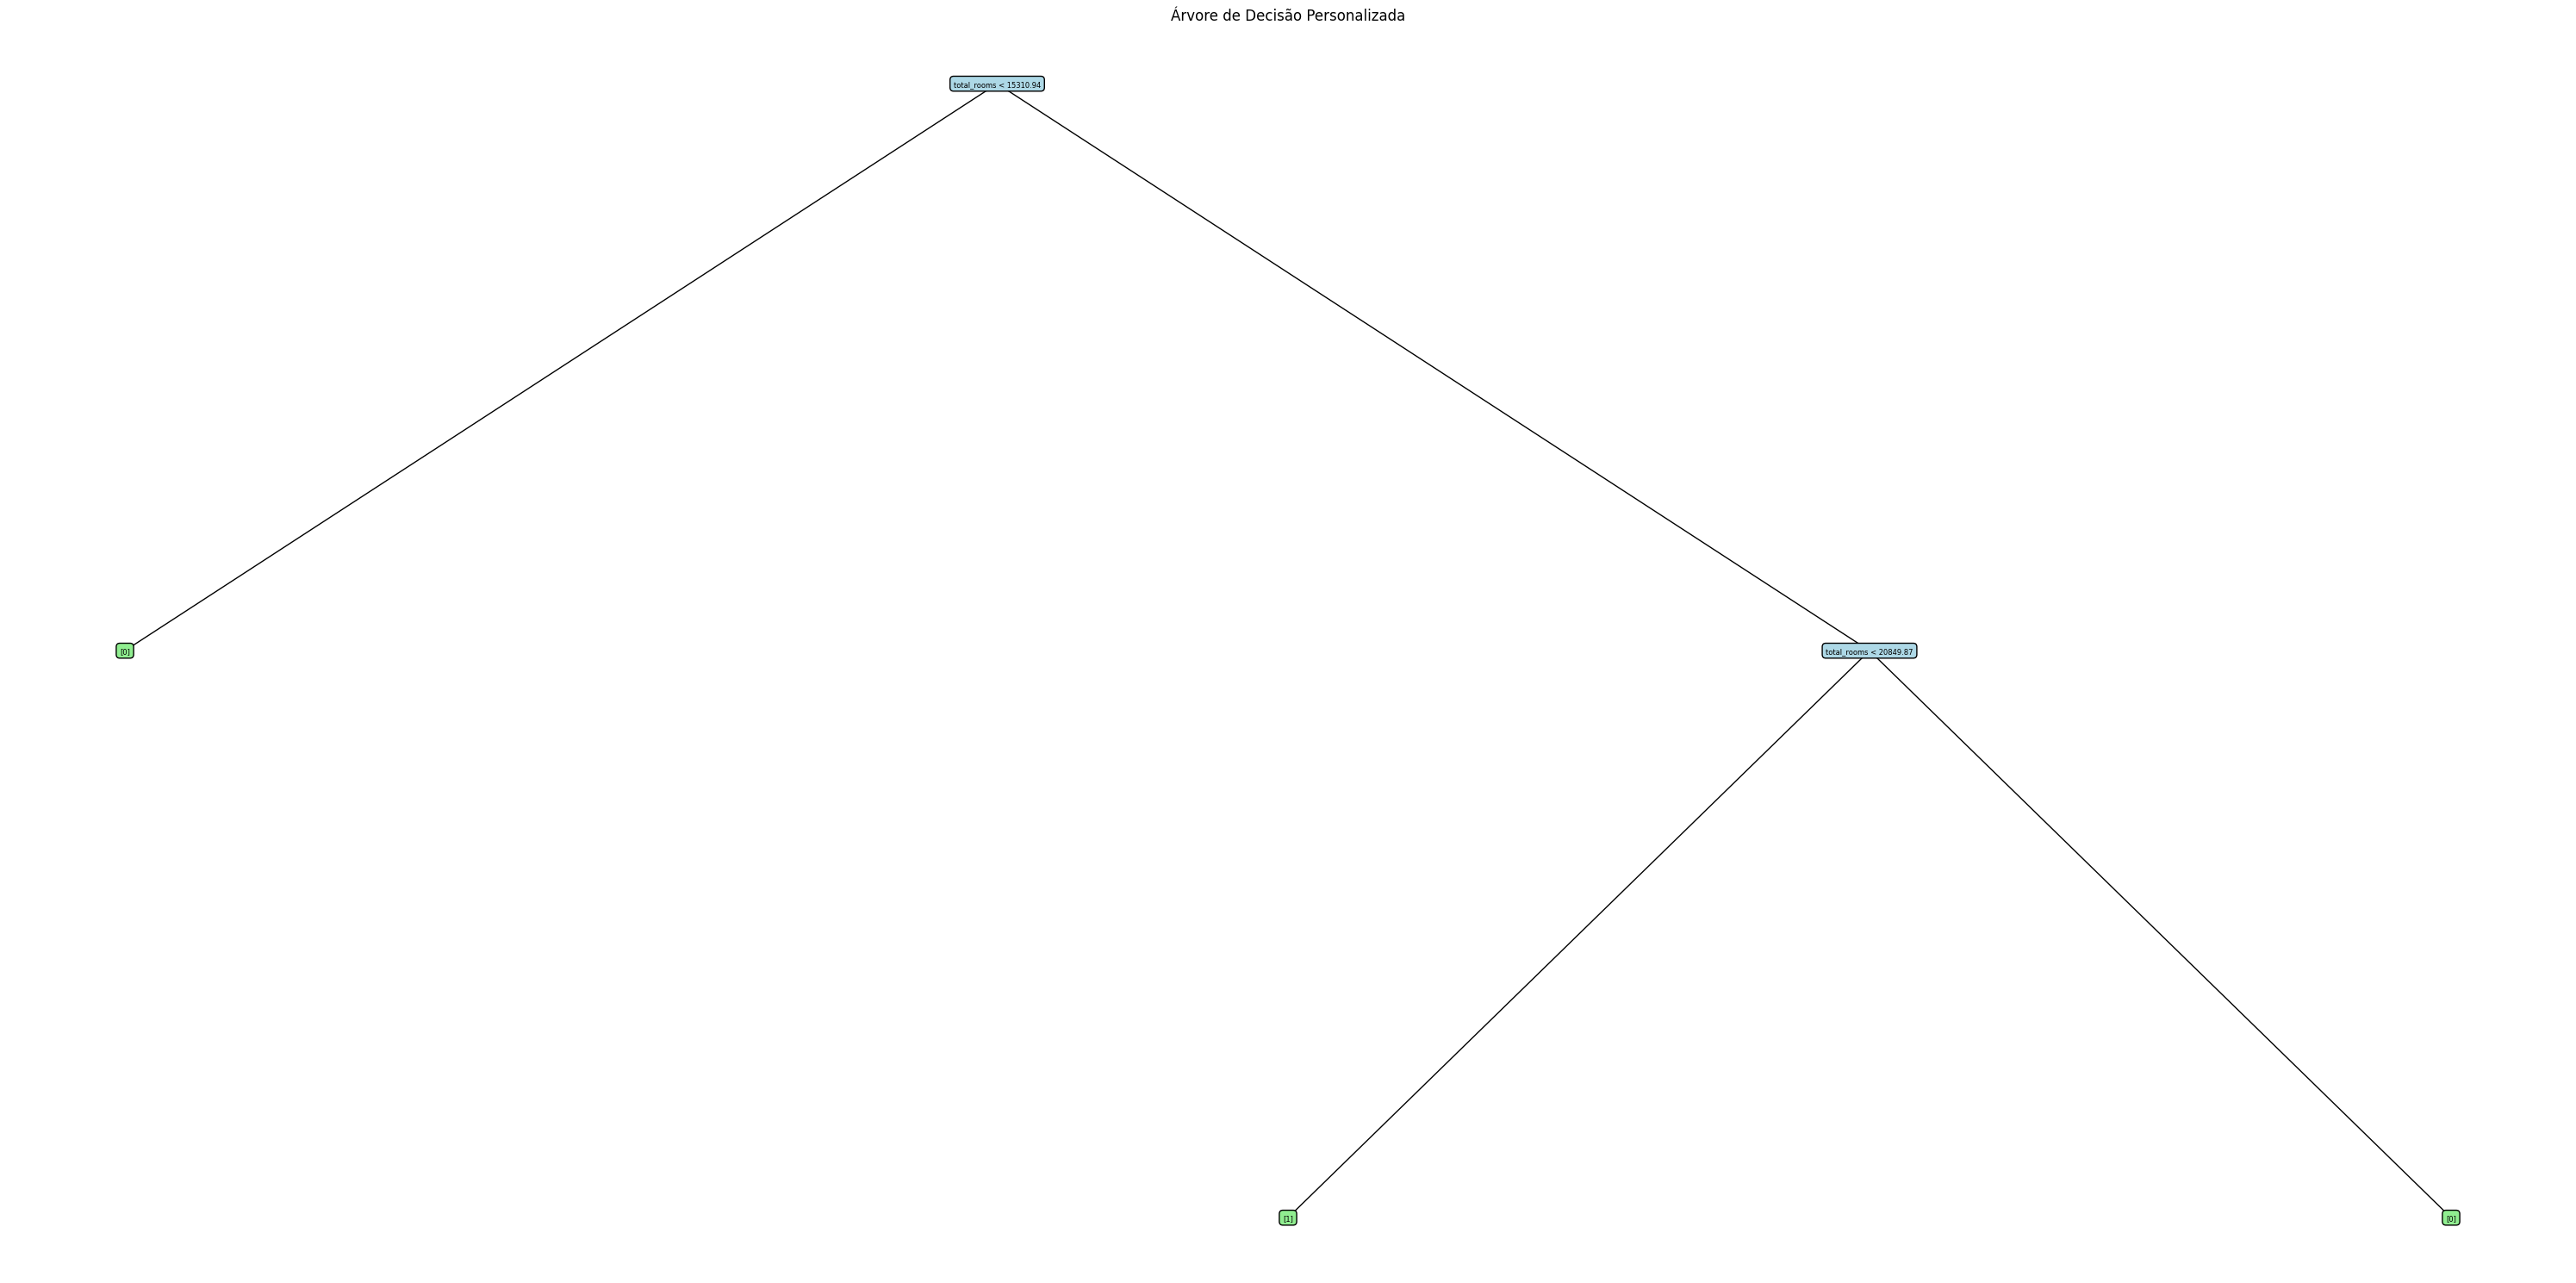


2. Árvore com Poda por Validação (Housing):


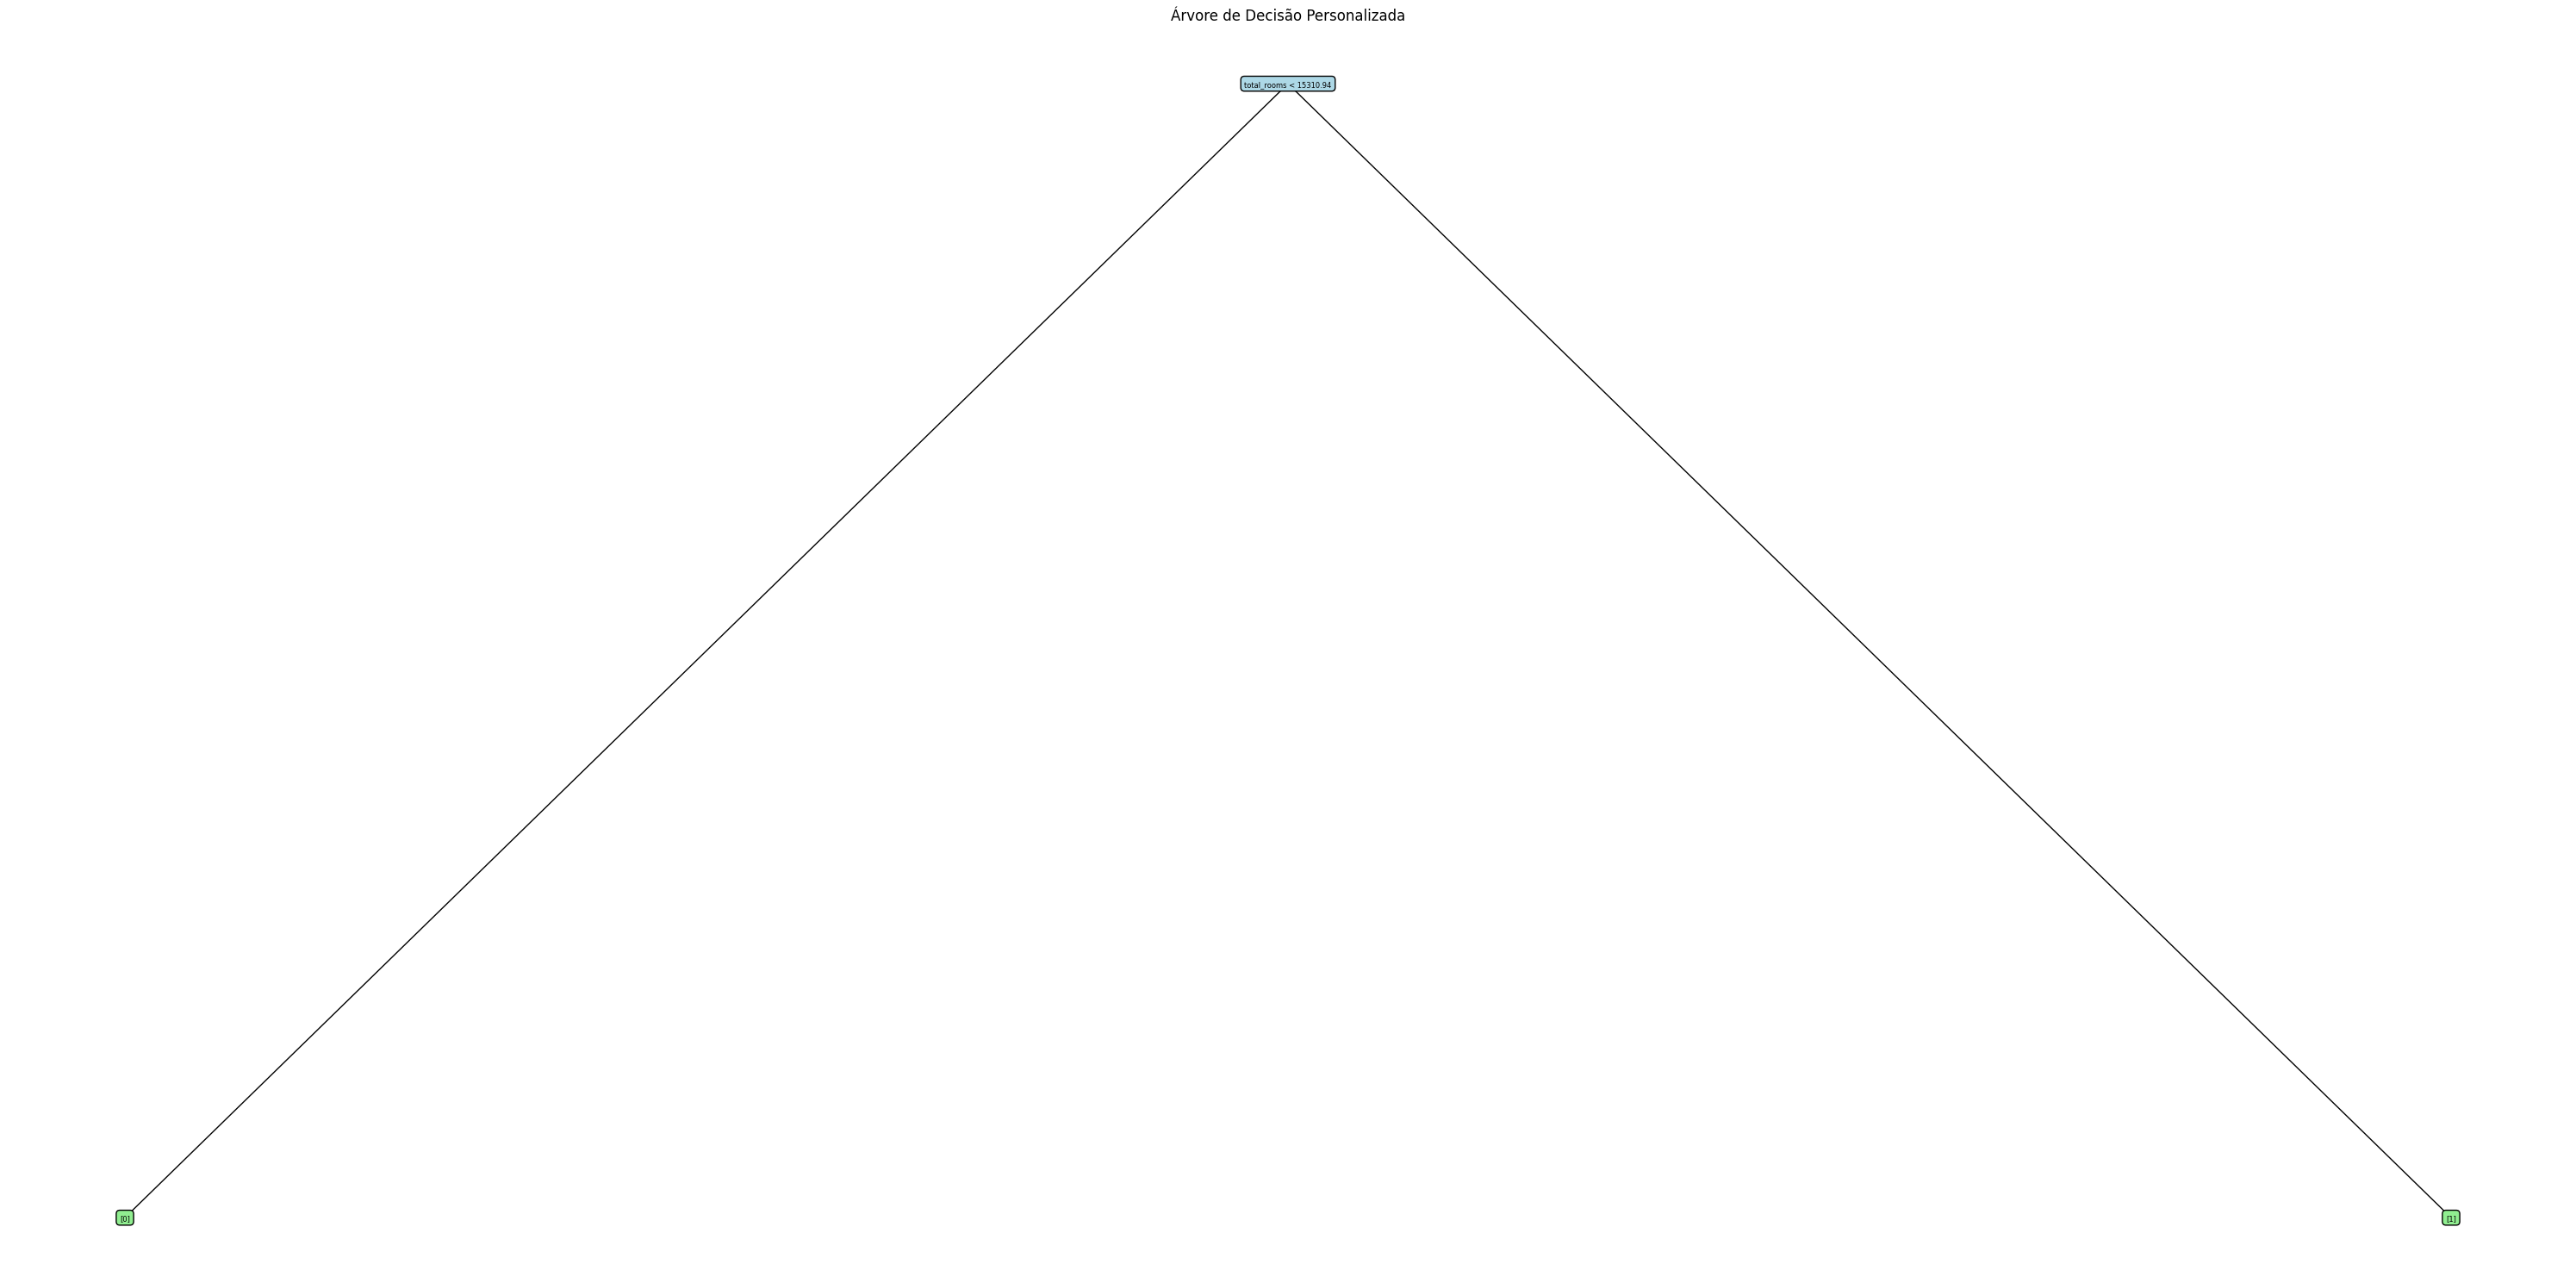


3. Árvore com Poda por Custo-Complexidade (Housing):


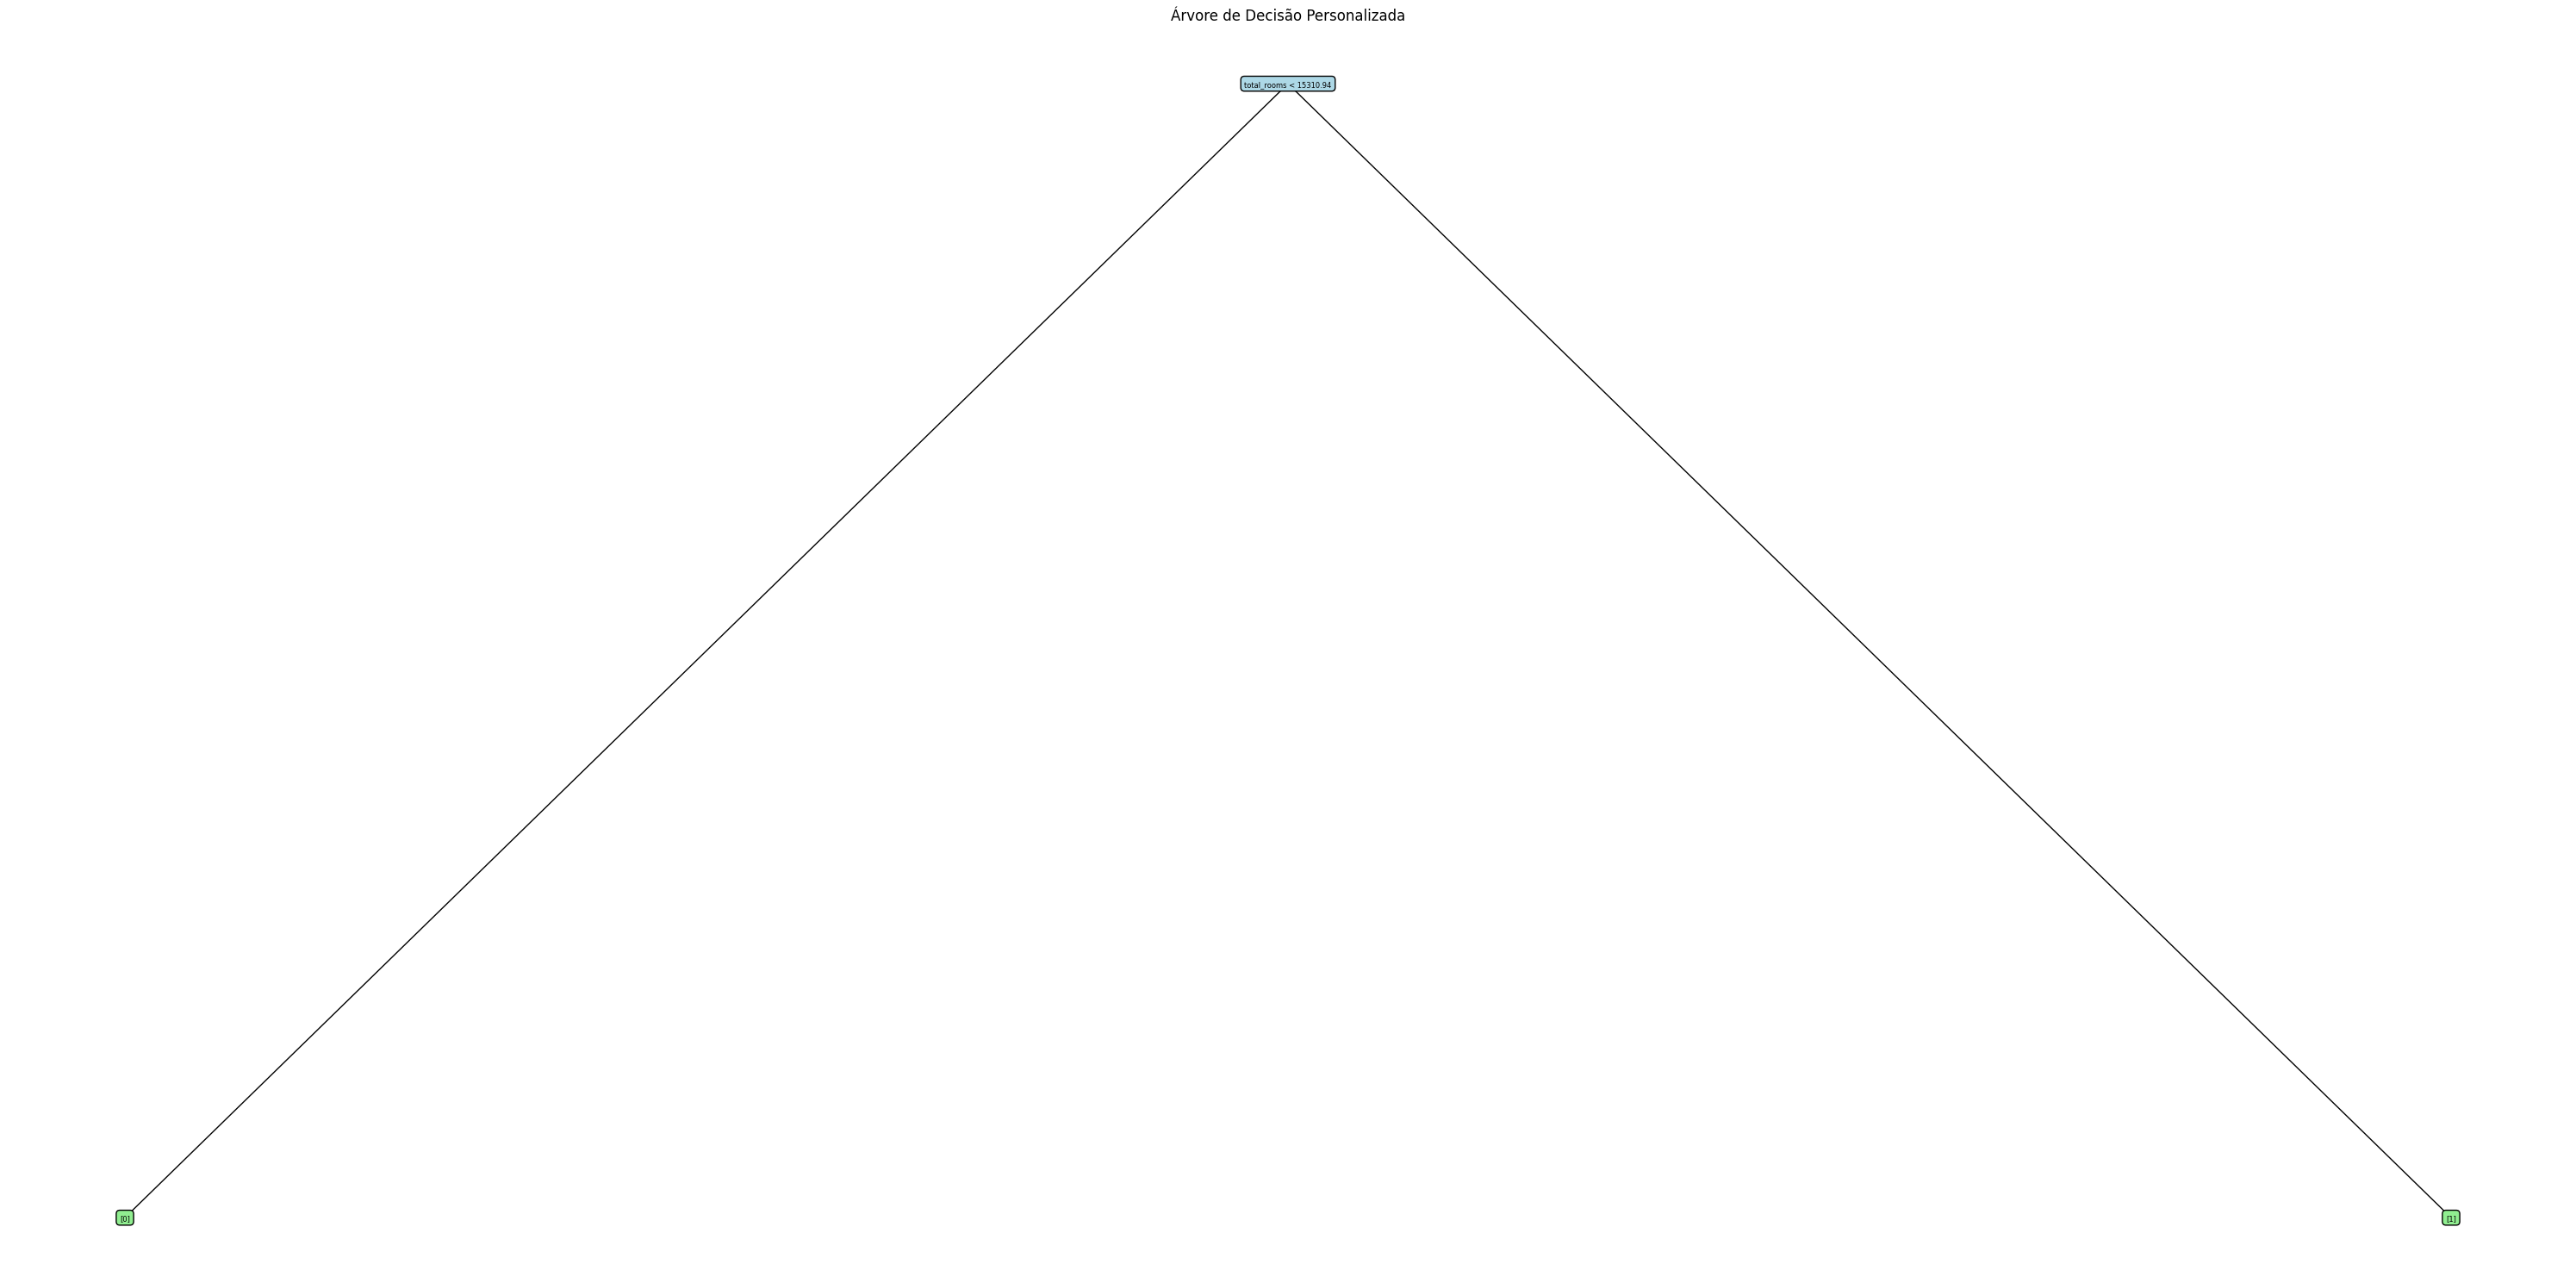


4. Árvore com Poda por Profundidade (Housing):


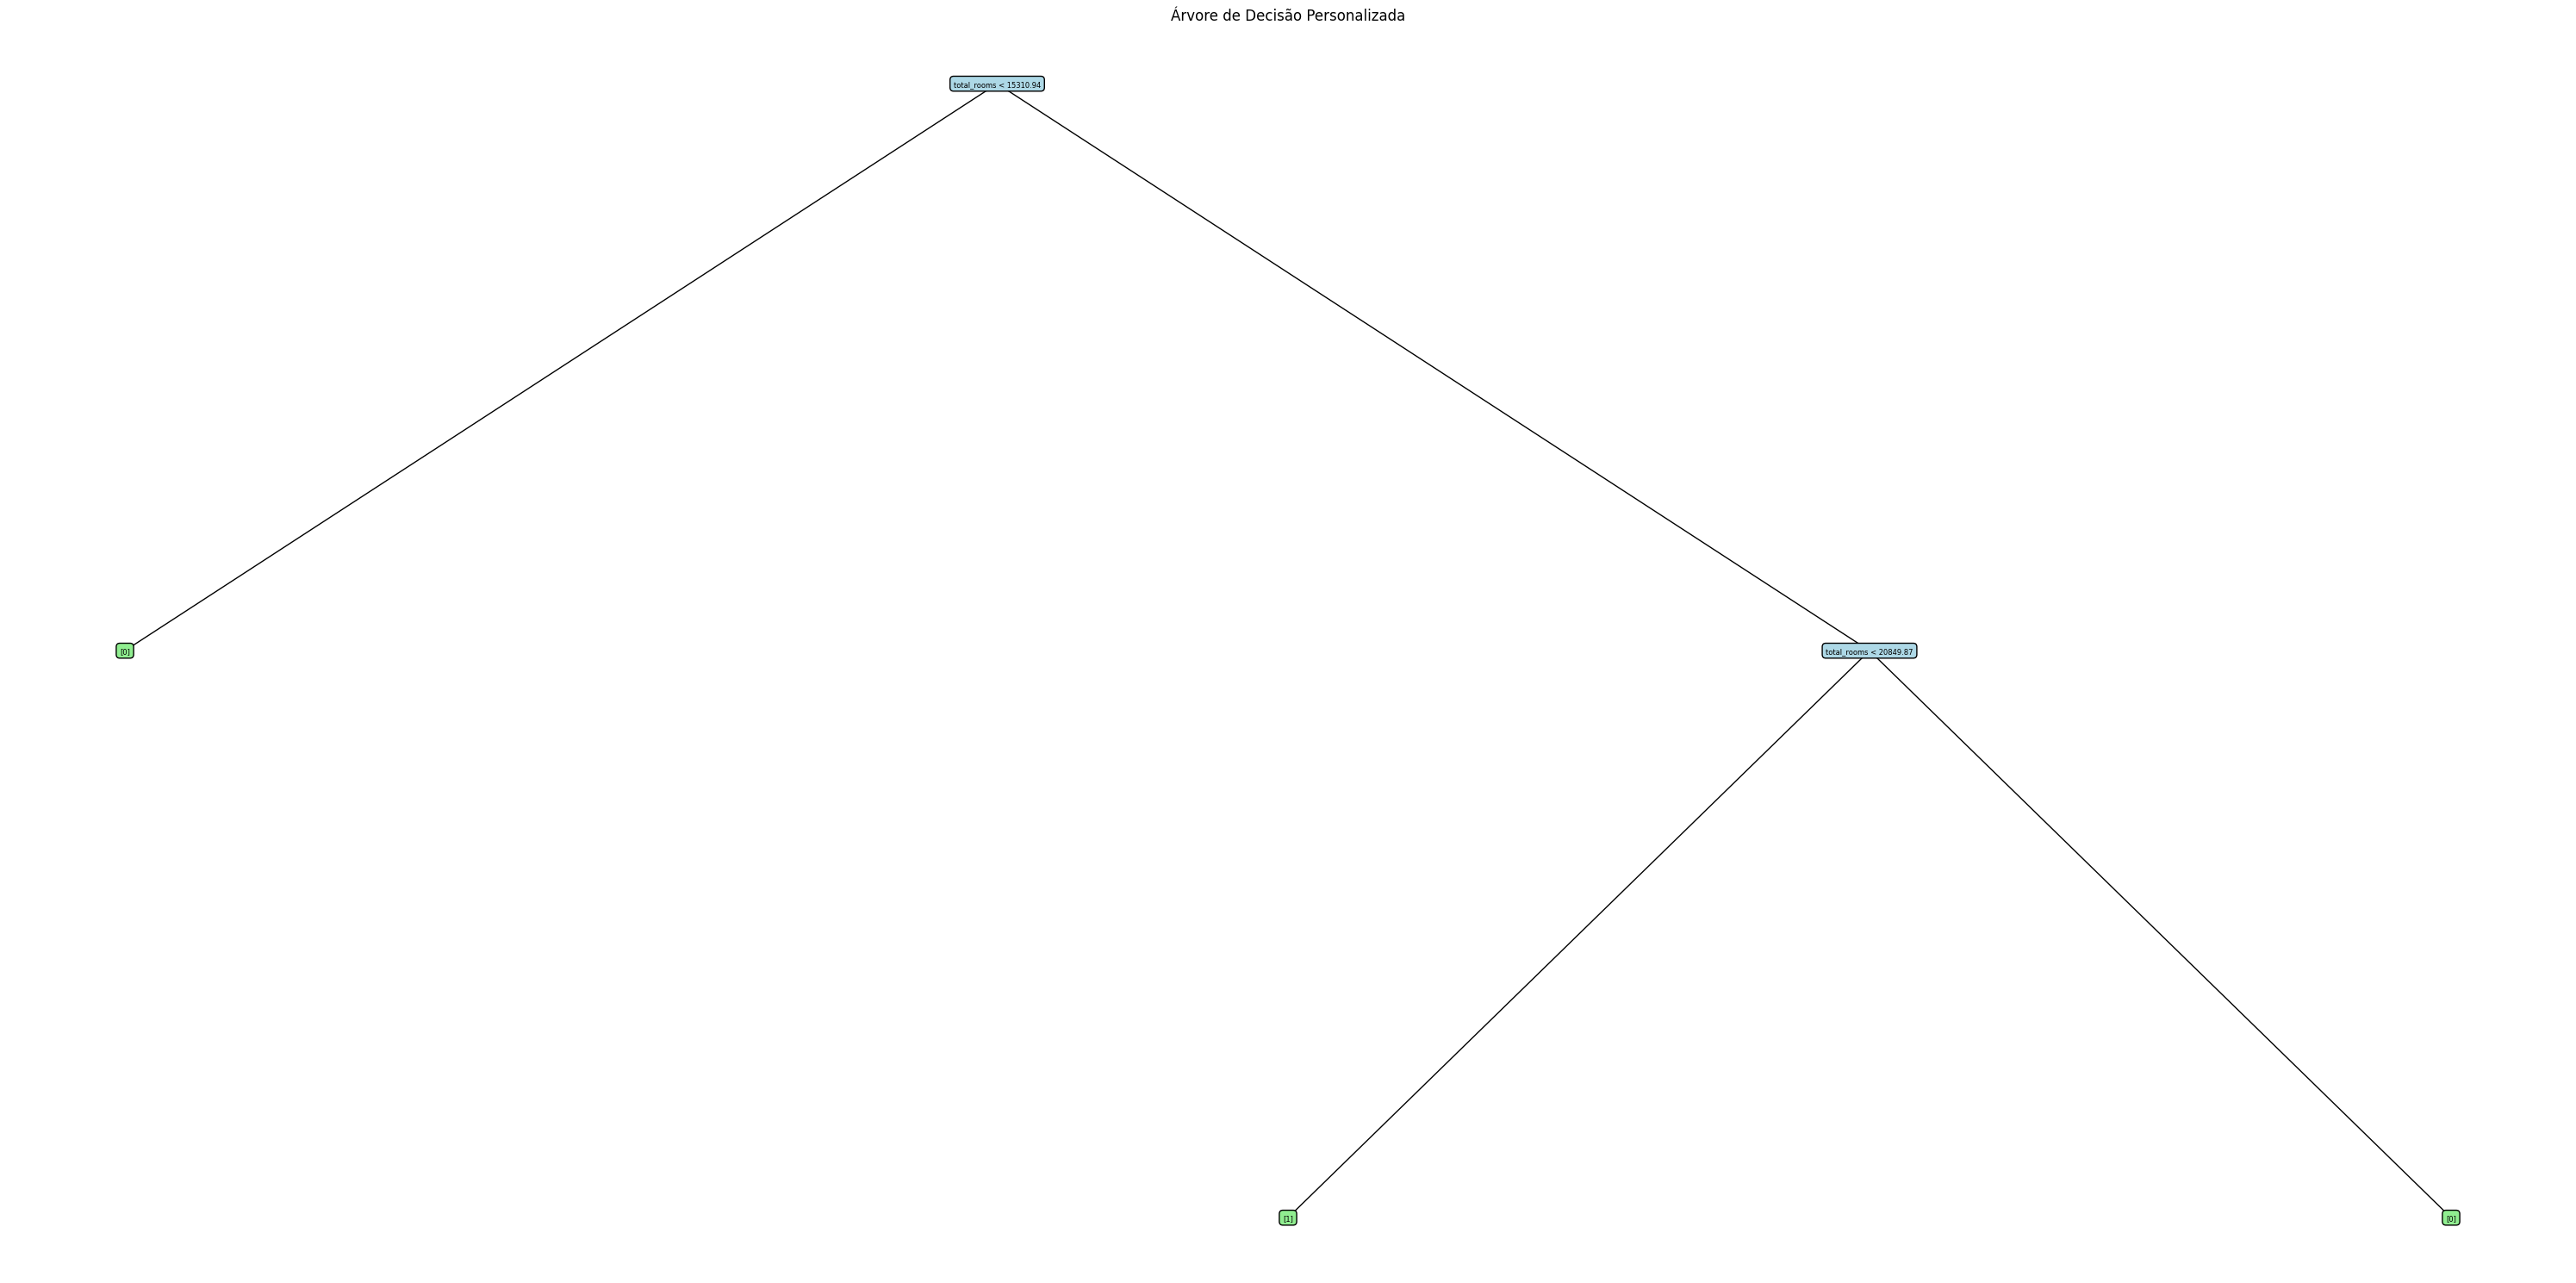

In [ ]:
# Visualizar as árvores podadas NOVAS
print("\n=== Visualizações das Árvores NOVAS ===")

print("\n1. Árvore Completa NOVA (Housing):")
plotar_arvore_dinamica(arvore_completa_novo, feature_names_novo)

print("\n2. Árvore com Poda por Validação NOVA (Housing):")
plotar_arvore_dinamica(arvore_poda_val_novo, feature_names_novo)

print("\n3. Árvore com Poda por Custo-Complexidade NOVA (Housing):")
plotar_arvore_dinamica(arvore_poda_custo_novo, feature_names_novo)

print("\n4. Árvore com Poda por Profundidade NOVA (Housing):")
plotar_arvore_dinamica(arvore_poda_prof_novo, feature_names_novo)